Импортируем зависимые библиотеки

In [14]:
import joblib
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.multiclass import OneVsOneClassifier
from config import cols
from config import primary_column
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.inspection import permutation_importance
from utils import flatten_cols, encoder

Выключаем вывод предупреждений

In [15]:
plt.style.use('ggplot')  # определяем стиль
warnings.filterwarnings('ignore')  # исключение конфигурационных строчек (варнинги)

Загружаем датасет

In [16]:
severity_df = pd.read_csv('./datasets/dataset.csv', encoding="utf-8", delimiter=";")

Преобразуем и фильтруем загруженный датасет

In [17]:
cols = flatten_cols(cols, 'name')
index_names = severity_df[severity_df['results_of_medical_examination'] == 'положительный'].index
severity_df.drop(index_names, inplace=True)
severity_ml = severity_df[cols]
severity_ml = severity_ml.dropna()

При необходимости используем кодировщик признаков OneHotEncoder

In [18]:
for col in cols:
    if "need_encode" in col:
        severity_ml[col["name"]] = severity_ml[col["name"]].astype("string")
        severity_ml = encoder(severity_ml, col["name"], True)

После кодировщика необходимо убрать пустые строки, а также отделить датасет от предсказываемых значений

In [19]:
severity_ml = severity_ml.dropna()
severity_train = severity_ml.drop(primary_column, axis=1)

Разбиваем полученный датасет на тренировочные образцы

In [20]:
X_train, X_test, y_train, y_test = train_test_split(severity_train.values,
                                                    severity_ml[primary_column].values,
                                                    test_size=0.2,
                                                    random_state=42)

Создаем объект класса RandomForestClassifier, обучаем модель на обработанных датасетах и предсказываем для сверки результатов

In [21]:
random_forest = RandomForestClassifier(n_estimators=200)
y_score = random_forest.fit(X_train, y_train).predict_proba(X_test)
result = random_forest.predict(X_test)

In [22]:
# Сохраняем обученую модель
joblib.dump(random_forest, 'model.sav')

['model.sav']

Вычисляем точность модели

In [23]:
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
print("Accuracy", acc_random_forest)
print(r2_score(y_test, result))

Accuracy 97.99
0.8212487585413919


Высчитываем корреляцию

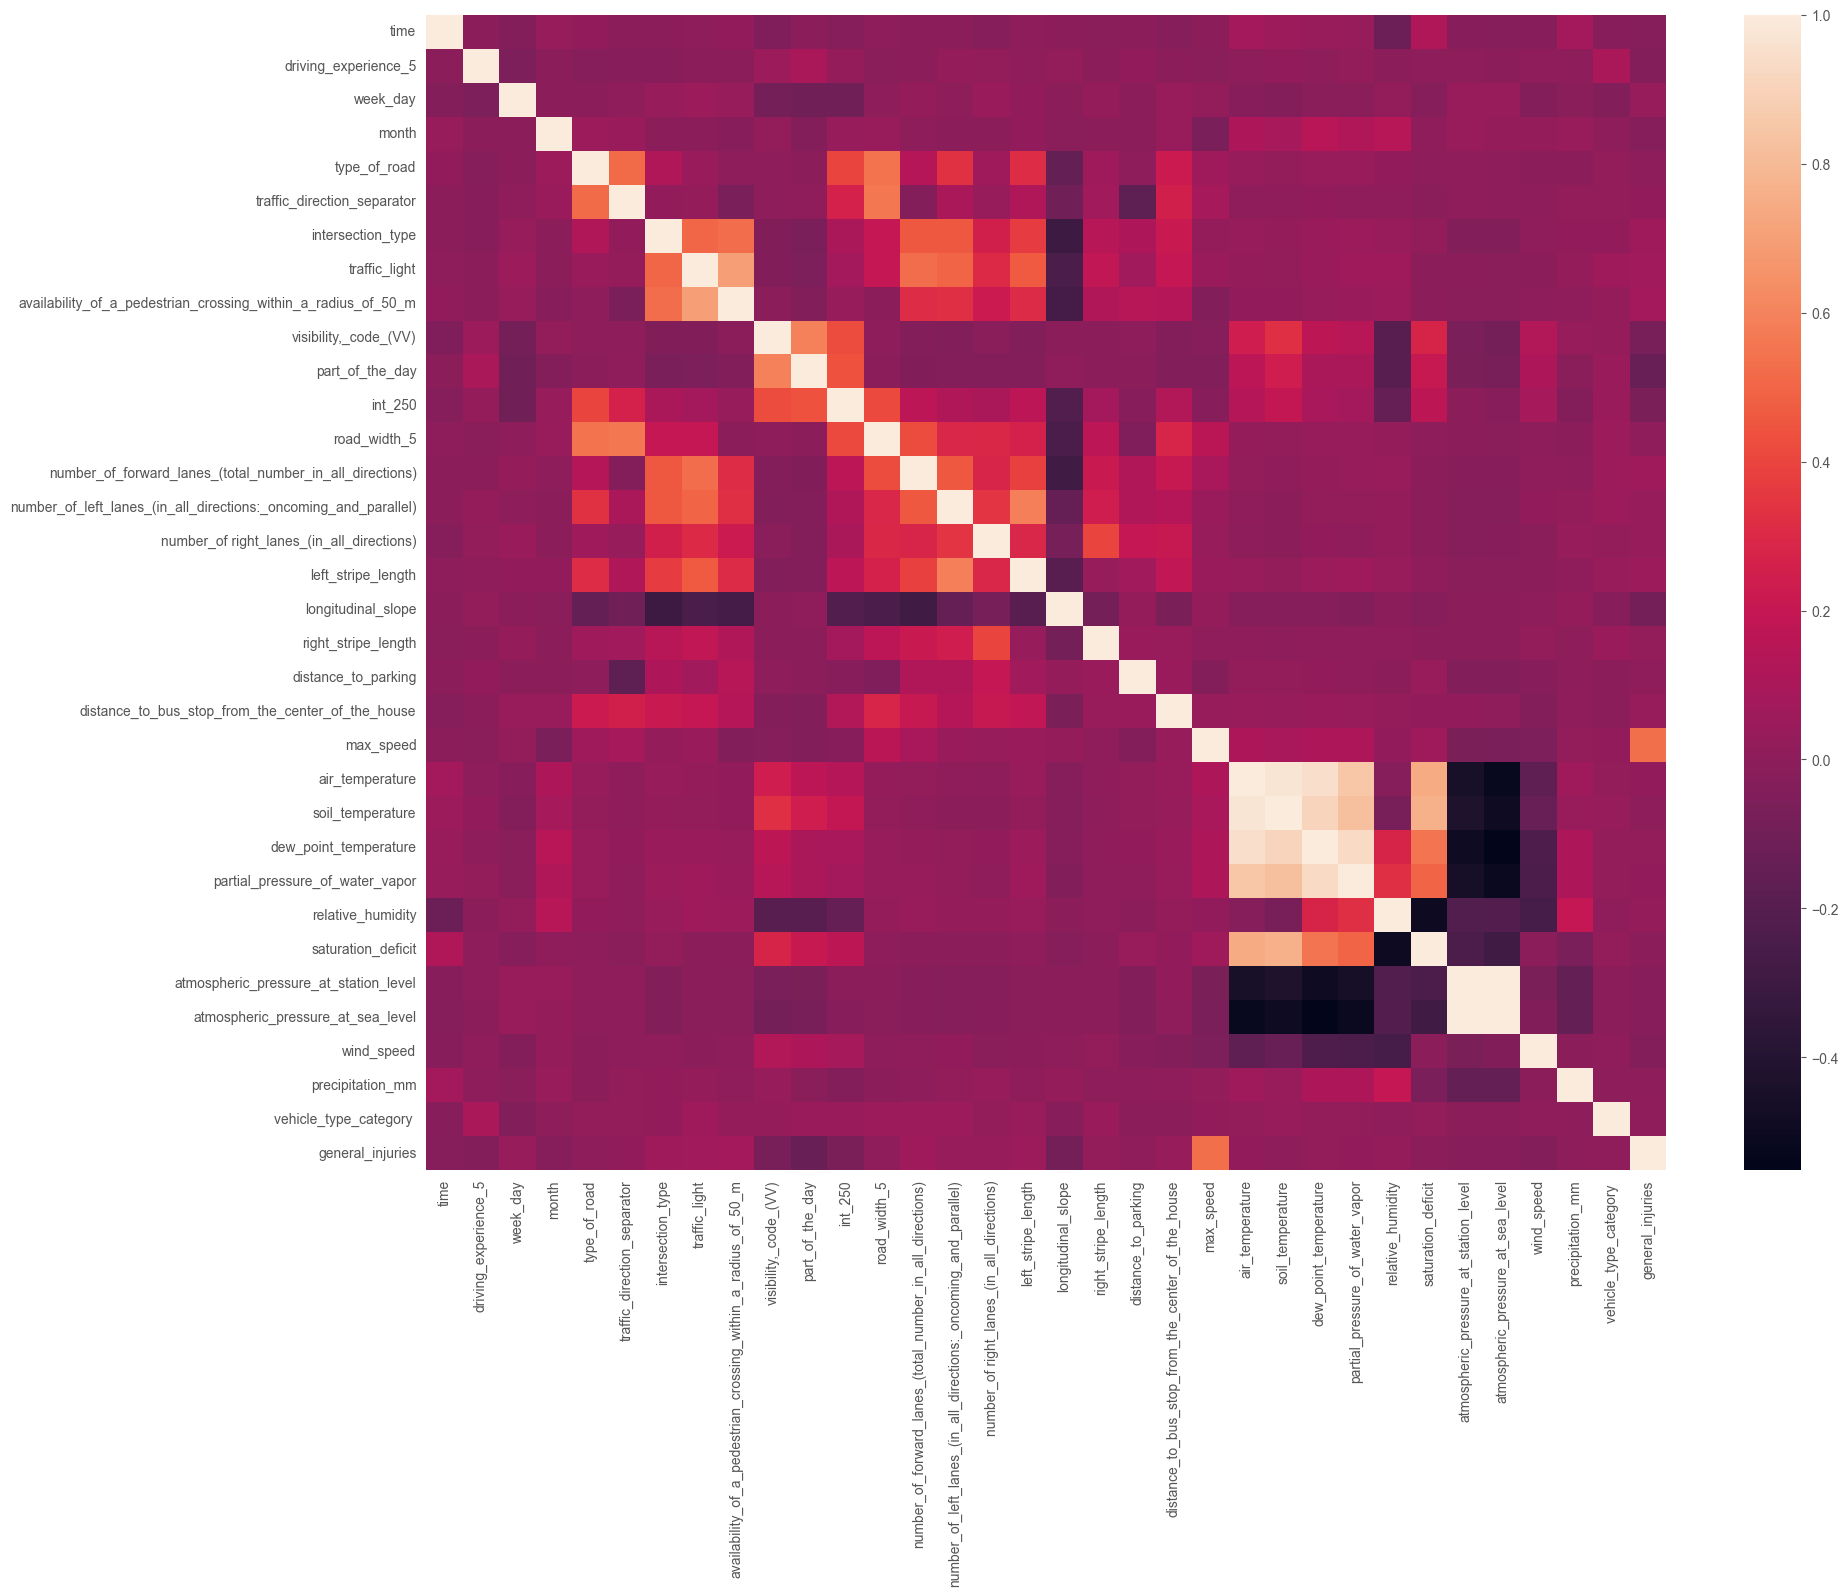

In [24]:
corr = severity_ml.corr()
plt.subplots(figsize=(20, 15))
sns.heatmap(corr)
plt.show()

Проводим перестановочный анализ значимости признаков

In [25]:
result = permutation_importance(random_forest, X_train, y_train, n_repeats=10, random_state=42)
importances = result.importances_mean
indices = np.argsort(importances)[::-1]
ar_f = []
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx], 4), cols[idx]])

ar_f.sort(reverse=True)
print(ar_f)

[[0.1658, 'max_speed'], [0.0044, 'availability_of_a_pedestrian_crossing_within_a_radius_of_50_m'], [0.0041, 'part_of_the_day'], [0.0036, 'time'], [0.0036, 'driving_experience_5'], [0.0032, 'road_width_5'], [0.0032, 'longitudinal_slope'], [0.003, 'int_250'], [0.0025, 'vehicle_type_category '], [0.0019, 'atmospheric_pressure_at_station_level'], [0.0018, 'atmospheric_pressure_at_sea_level'], [0.0017, 'air_temperature'], [0.0016, 'relative_humidity'], [0.0014, 'soil_temperature'], [0.0014, 'distance_to_bus_stop_from_the_center_of_the_house'], [0.0013, 'number_of_forward_lanes_(total_number_in_all_directions)'], [0.0012, 'week_day'], [0.0012, 'distance_to_parking'], [0.0011, 'saturation_deficit'], [0.0011, 'dew_point_temperature'], [0.001, 'partial_pressure_of_water_vapor'], [0.001, 'left_stripe_length'], [0.0007, 'traffic_light'], [0.0007, 'intersection_type'], [0.0006, 'right_stripe_length'], [0.0005, 'wind_speed'], [0.0005, 'month'], [0.0004, 'visibility,_code_(VV)'], [0.0004, 'type_of_r

Строим график значимости признаков

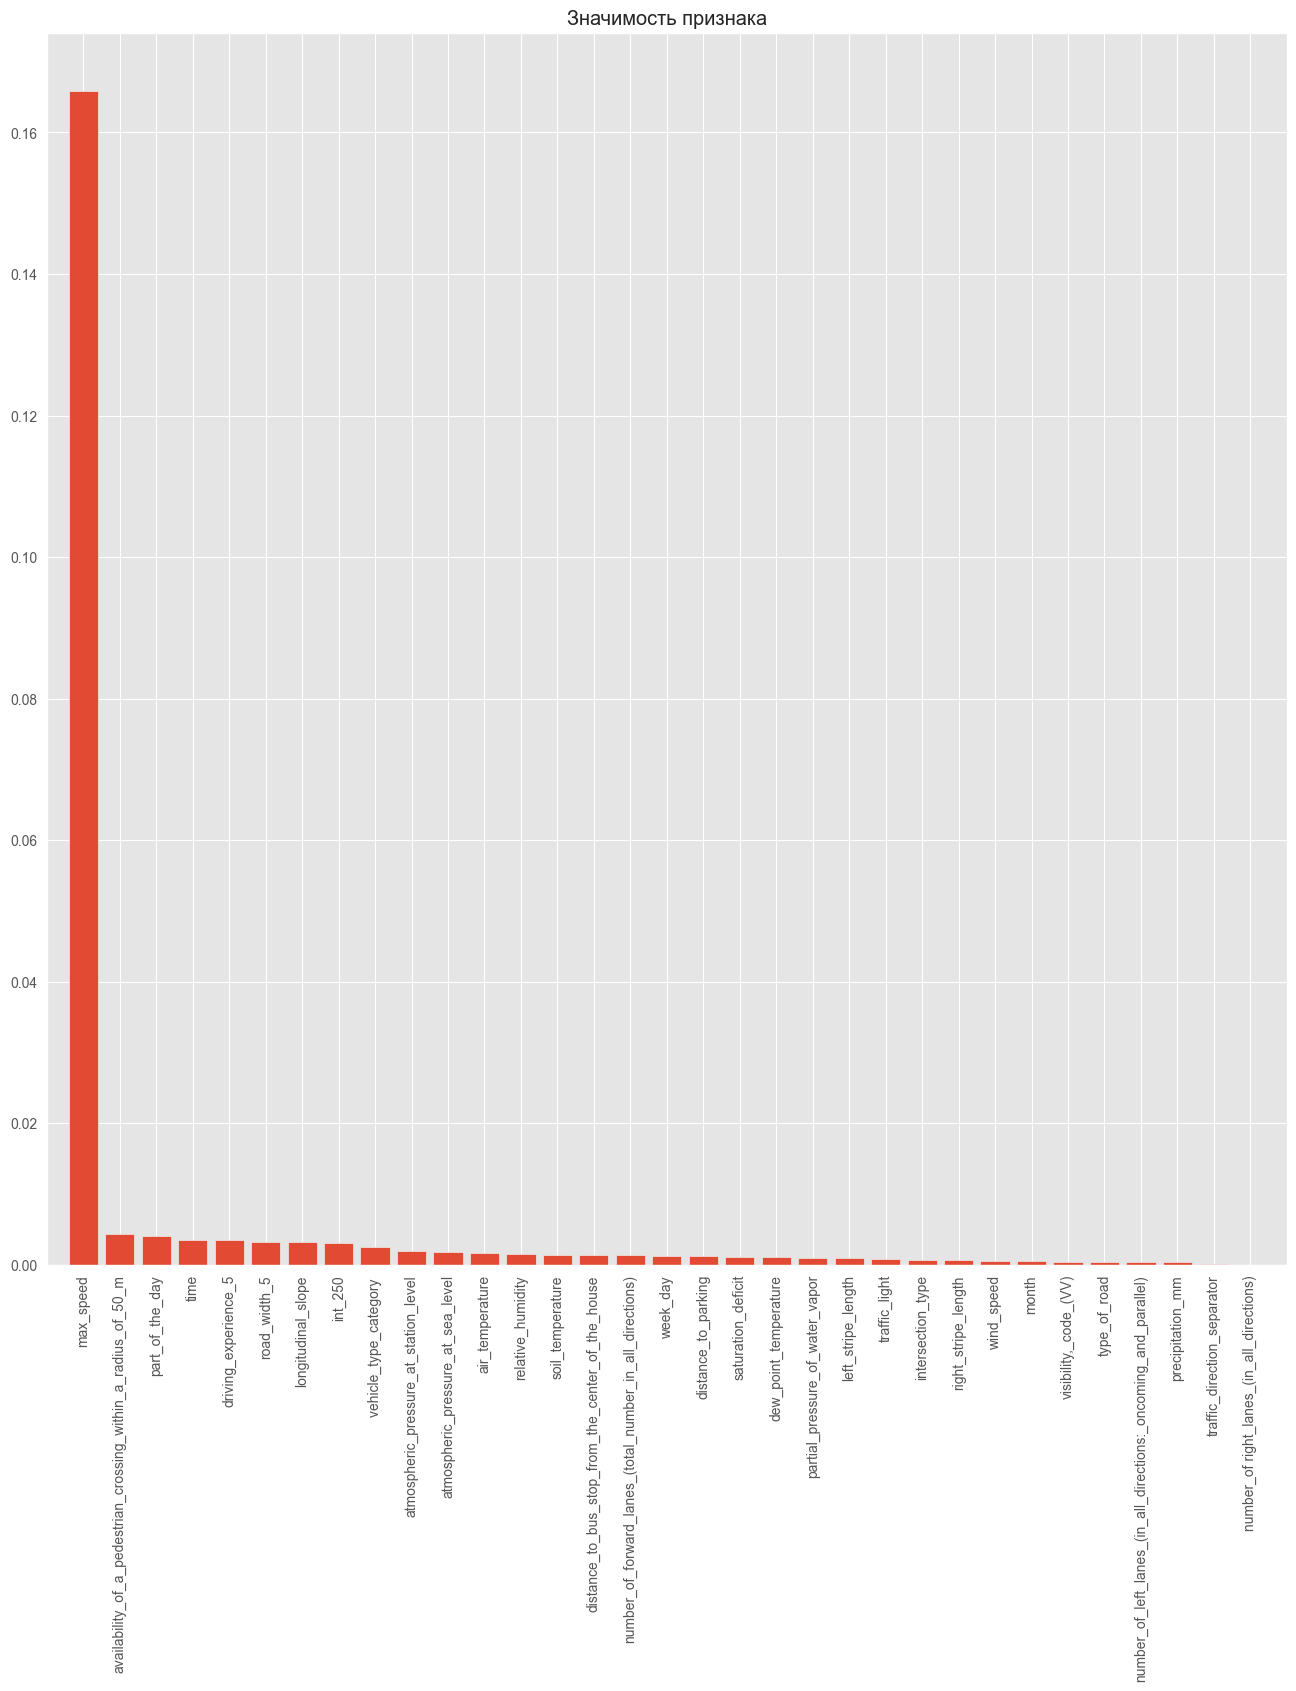

In [26]:
d_first = len(cols) - 1
plt.figure(figsize=(16, 16))
plt.title("Значимость признака")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(cols)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first])
plt.show()

Матрица количества правильно- и ошибочно- угаданных классов

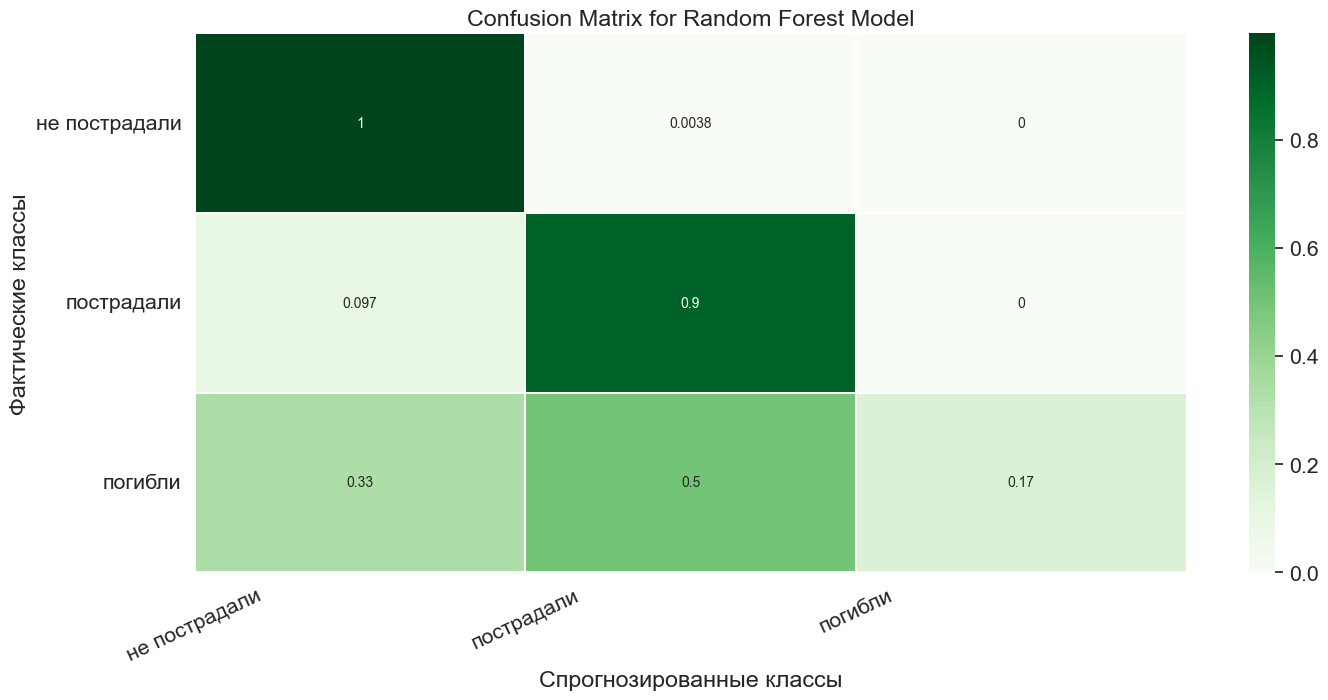

In [28]:
matrix = confusion_matrix(y_test, random_forest.predict(X_test))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(16, 7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size': 10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ["не пострадали", "пострадали", "погибли"]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Спрогнозированные классы')
plt.ylabel('Фактические классы')
plt.title('Confusion Matrix for Random Forest Model')

plt.show()

Базовые метрики оценки точности модели

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, random_forest.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1319
         1.0       0.96      0.90      0.93       217
         2.0       1.00      0.17      0.29         6

    accuracy                           0.98      1542
   macro avg       0.98      0.69      0.74      1542
weighted avg       0.98      0.98      0.98      1542


ROC-анализ

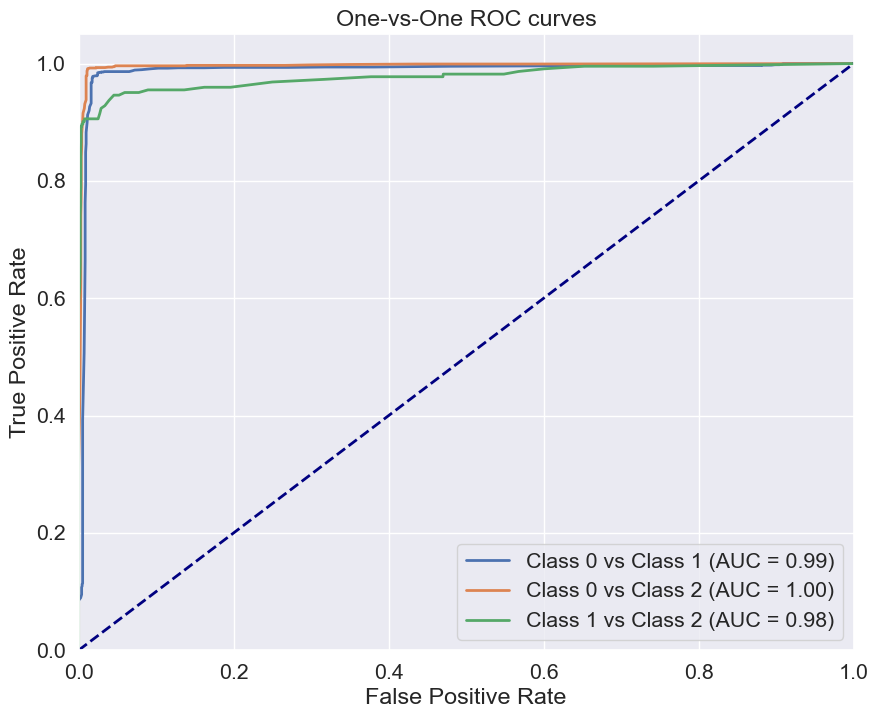

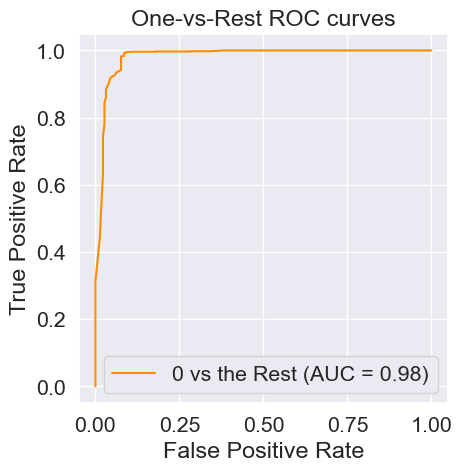

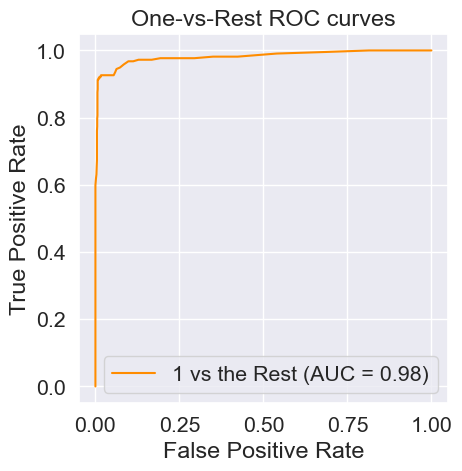

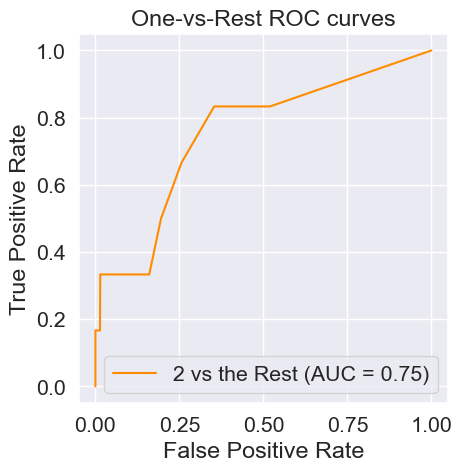

In [30]:
# Создание OneVsOneClassifier
ovo_clf = OneVsOneClassifier(RandomForestClassifier())
# Обучение классификатора
ovo_clf.fit(X_train, y_train)
# Получение меток классов в формате One-Hot Encoding
label_binarizer = LabelBinarizer()
y_onehot_test = label_binarizer.fit_transform(y_test)

# Получение оценок вероятностей для каждого класса
y_score = ovo_clf.decision_function(X_test)

plt.figure(figsize=(10, 8))

# Создаем комбинации всех классов для построения ROC-кривых
class_combinations = [(i, j) for i in range(3) for j in range(i + 1, 3)]

for class_1, class_2 in class_combinations:
    class_1_id, class_2_id = class_1, class_2

    y_true = np.concatenate([y_onehot_test[:, class_1_id], y_onehot_test[:, class_2_id]])
    y_score_pair = np.concatenate([y_score[:, class_1_id], y_score[:, class_2_id]])

    fpr, tpr, _ = roc_curve(y_true, y_score_pair)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'Class {class_1} vs Class {class_2} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-One ROC curves')
plt.legend(loc="lower right")

# ROC запускаем цикл, узнаем размерность матрици, чтобы создать диапазон итераций. lass_of_interest -   номер группы интенсивности
for class_of_interest in range(0, y_onehot_test.shape[1]):
     class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
     RocCurveDisplay.from_predictions(
         y_onehot_test[:, class_id],
         y_score[:, class_id],
         name=f"{class_of_interest} vs the Rest",
         color="darkorange",)
     plt.axis("square")
     plt.xlabel("False Positive Rate")
     plt.ylabel("True Positive Rate")
     plt.title("One-vs-Rest ROC curves")
     plt.legend()

plt.show()